In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [4]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.addpgpd_sampled import ADpgpdSampled
from src.algorithms.nnpgpd import Nnpgpd
from src.sampling import Sampler

In [5]:
ds = 4
da = 2

tau = 0.1
gamma = 0.9
alpha = 1.0

b = -1

In [6]:
G = - torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
]).double()

R =  - torch.tensor([
    [0.1, 0],
    [0, 0.1],
]).double()

def primal_reward_fn(env, a):
    return ((env.s @ G) * env.s).sum(dim=1) + ((a @ R) * a).sum(dim=1)

def dual_reward_fn(env, a):
    #return 100 * (s[:, 0].sign().clip(max=0.0) + s[:, 1].sign().clip(max=0.0)).clip(min=-1)
    return 100 * (env.s[:, 0].clip(max=1.0) + env.s[:, 1].clip(max=1.0) - 2)

def starting_pos_fn(nsamples):
        rng = np.random.default_rng()

        s = torch.tensor(rng.uniform(
            low=[1, 1, -10, -10],
            high= [100, 100, 10, 10],
            size=[nsamples, 4],
        )).double()

        a = torch.tensor(rng.uniform(
            low=[-10, -10],
            high= [10, 10],
            size=[nsamples, 2],
        )).double()

        return s, a

In [137]:
epochs = 500
n_pe = 100
n_rho = 1_000
n_roll = 200

gamma = 0.95
eta = 0.01

env = RobotWorld(range_pos=[1., 100.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

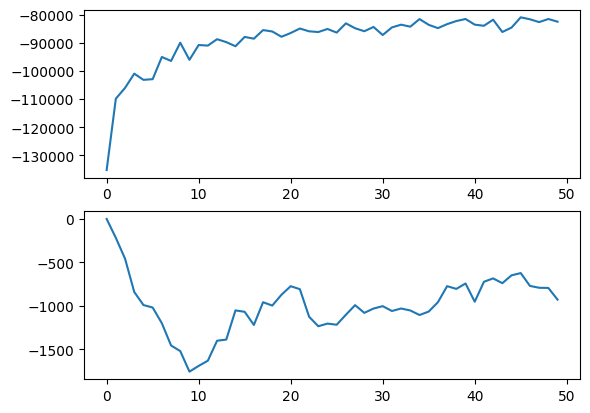

In [139]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[1].plot(losses_dual)
plt.show()

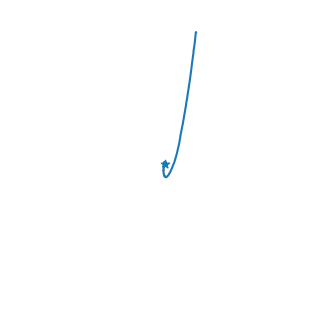

In [167]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axis('off')
plt.show()

In [46]:
epochs = 10_000
n_pe = 100
n_rho = 10_000
n_roll = 200

gamma = 0.95

eta = 0.00005

b = - 5.0
# b -2 and eta 0.001

env = RobotWorld(range_pos=[1., 100.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

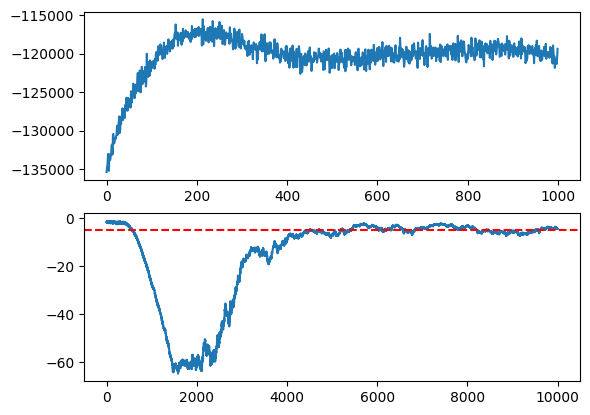

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
#axes[0].axhline(y=-910, color='r', linestyle='--')
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

In [48]:
np.save('../results/obs_primal.npy', losses_primal)
np.save('../results/obs_dual.npy', losses_dual)

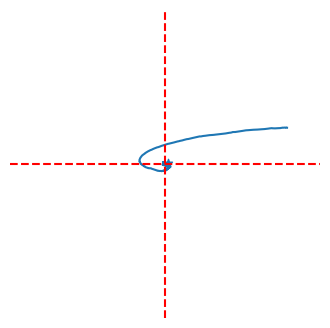

In [145]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter(states[-1, 0], states[-1, 1], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.axis('off')
plt.show()

# Neural netowrk

In [113]:
b = - 5
gamma = 0.95

n_epochs = 10_000
n_episodes = 1
n_samples = 100
n_rollout = 200
n_rho = 1_000

num_features = 512
lr_actor = 2e-6
lr_critic = 2e-6
lr_dual = 1e-3

env = RobotWorld(range_pos=[1., 100.], range_vel=[-.1, .1])

nnpgpd = Nnpgpd(ds, da, env, num_features, lr_actor, lr_critic, lr_dual, gamma, b, starting_pos_fn, primal_reward_fn, dual_reward_fn)
loss_primal, loss_dual = nnpgpd.train(n_epochs, n_episodes, n_samples, n_rollout, n_rho)

Epoch 0 - Primal -133803.43466612353 - Dual -1.1085329207677908 - Lambda 0.0


Epoch 10 - Primal -131101.8631512006 - Dual -11.53735871420861 - Lambda 0.03430808335542679
Epoch 20 - Primal -135336.99001823118 - Dual -4.59383139467845 - Lambda 0.047212302684783936
Epoch 30 - Primal -126977.10687608561 - Dual -8.055795919753477 - Lambda 0.09533889591693878
Epoch 40 - Primal -132726.63018869856 - Dual -10.173001044390636 - Lambda 0.13296079635620117
Epoch 50 - Primal -136139.80796142406 - Dual -9.437326029123403 - Lambda 0.17124855518341064
Epoch 60 - Primal -132112.31455928524 - Dual -6.432842072467087 - Lambda 0.20139656960964203
Epoch 70 - Primal -138235.10785444884 - Dual -7.194830051655443 - Lambda 0.22780965268611908
Epoch 80 - Primal -131960.59163674622 - Dual -8.268113331745823 - Lambda 0.25159335136413574
Epoch 90 - Primal -134946.95003177755 - Dual -8.0190411146767 - Lambda 0.27860432863235474
Epoch 100 - Primal -139206.33303073858 - Dual -5.458483249576097 - Lambda 0.30883583426475525
Epoch 110 - Primal -132886.18378521345 - Dual -7.619157520803917 - Lamb

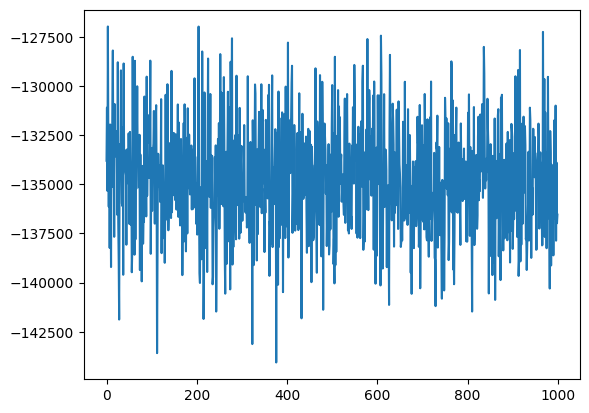

In [114]:
plt.plot(loss_primal);

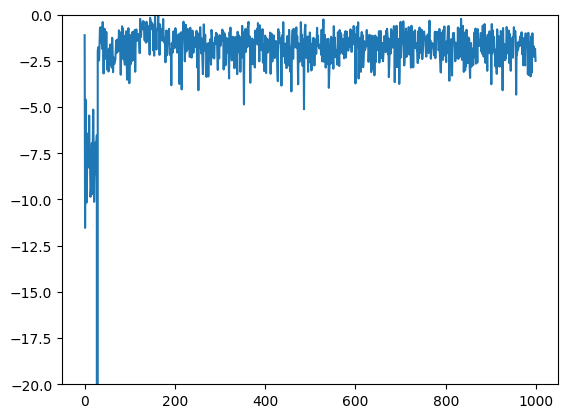

In [117]:
plt.plot(loss_dual)
plt.ylim(-20, 0);

In [118]:
np.save('../results/obs_primal_nn.npy', loss_primal)
np.save('../results/obs_dual_nn.npy', loss_dual)

In [ ]:
G = - torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, 0.01, 0],
    [0, 0, 0, 0.01]
]).double()

R =  - torch.tensor([
    [0.1, 0],
    [0, 0.1],
]).double()

def primal_reward_fn(env, a):
    return ((env.s @ G) * env.s).sum(dim=1) + ((a @ R) * a).sum(dim=1)

def dual_reward_fn(env, a):
    #return 100 * (s[:, 0].sign().clip(max=0.0) + s[:, 1].sign().clip(max=0.0)).clip(min=-1)
    return 100 * (env.s[:, 0].clip(max=1.0) + env.s[:, 1].clip(max=1.0) - 2)

def starting_pos_fn(nsamples):
        rng = np.random.default_rng()

        s = torch.tensor(rng.uniform(
            low=[1, 1, -10, -10],
            high= [100, 100, 10, 10],
            size=[nsamples, 4],
        )).double()

        a = torch.tensor(rng.uniform(
            low=[-10, -10],
            high= [10, 10],
            size=[nsamples, 2],
        )).double()

        return s, a

In [ ]:
epochs = 300
n_pe = 100
n_rho = 1_000
n_roll = 200

gamma = 0.95
eta = 0.01

env = RobotWorld(range_pos=[1., 100.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

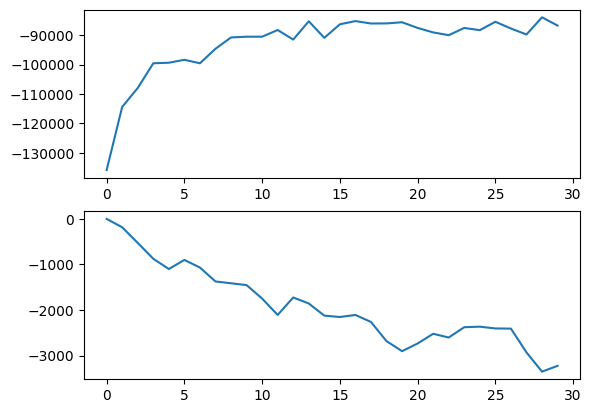

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[1].plot(losses_dual)
plt.show()

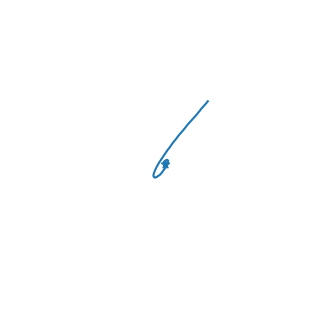

In [ ]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axis('off')
plt.show()

In [ ]:
epochs = 50_000
n_pe = 100
n_rho = 10_000
n_roll = 200

gamma = 0.95

eta = 0.00001

b = - 20.0
# b -2 and eta 0.001

env = RobotWorld(range_pos=[1., 100.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

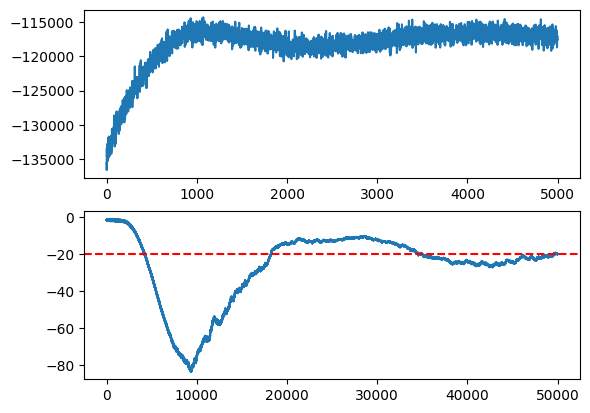

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
#axes[0].axhline(y=-910, color='r', linestyle='--')
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

In [ ]:
np.save('../results/obs_primal.npy', losses_primal)
np.save('../results/obs_dual.npy', losses_dual)

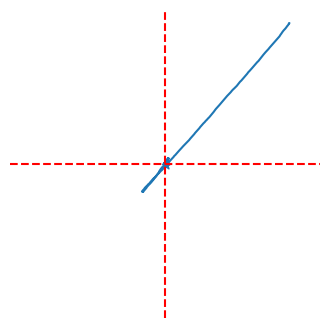

In [ ]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter(states[-1, 0], states[-1, 1], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.axis('off')
plt.show()